In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

### train a detection/segmentation model for images with ships

**idea : rather than fine tuning imagenet for detection/segmentation fine tune with the fine tuned model for ship classifier** 

- train_seg_lbs : images in train_all folder with segmentation
- test_seg_lbs : images in test_all folder with segmentation

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [4]:
files

[PosixPath('../DATA/airbus-ship/train_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/train_all_labels.csv'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/train_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/test_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/e5bcb0727.jpg'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/test_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/train_all'),
 PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/tmp')]

### create csv files

In [5]:
os.makedirs(path/"segmentations", exist_ok=True)

train_all_lbs = pd.read_csv(path/"train_all_lbs.csv")
test_all_lbs = pd.read_csv(path/"test_all_lbs.csv")

train_ids = train_all_lbs.ImageId.tolist()
test_ids = test_all_lbs.ImageId.tolist()

train_seg_lbs = pd.read_csv(path/"train_ship_segmentations.csv")
test_seg_lbs = pd.read_csv(path/"test_ship_segmentations.csv")

all_seg_lbs = pd.concat([train_seg_lbs.iloc[:, :2], test_seg_lbs.iloc[:, :2]])
all_seg_lbs = all_seg_lbs[~all_seg_lbs.EncodedPixels.isna()]

train_seg_lbs = all_seg_lbs[all_seg_lbs.ImageId.isin(train_ids)].reset_index(drop=True)
test_seg_lbs = all_seg_lbs[all_seg_lbs.ImageId.isin(test_ids)].reset_index(drop=True)

In [11]:
len(train_seg_lbs), len(test_seg_lbs)

(73605, 8118)

In [12]:
train_seg_lbs.to_csv(path/"segmentations/train_seg_lbs.csv", index=False)
test_seg_lbs.to_csv(path/"segmentations/test_seg_lbs.csv", index=False)

In [32]:
train_seg_lbs.shape, test_seg_lbs.shape 

((73605, 2), (8118, 2))

### visualize segmentation data

In [5]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [6]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [7]:
# get all masks
img_ids = train_seg_lbs.ImageId.unique() # pick an image from training folder
img_id = np.random.choice(img_ids)
rles = train_seg_lbs[train_seg_lbs.ImageId == img_id]['EncodedPixels'].values
print(f"number of masks : {len(rles)}")

number of masks : 2


In [8]:
# get image and mask
img = open_image(str(path/"train_all"/img_id))
masks = sum([rle_decode(rle, img.shape[:2]) for rle in rles])

In [9]:
def show_imgmasks(img, masks):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(masks)
    axarr[2].imshow(img)
    axarr[2].imshow(masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

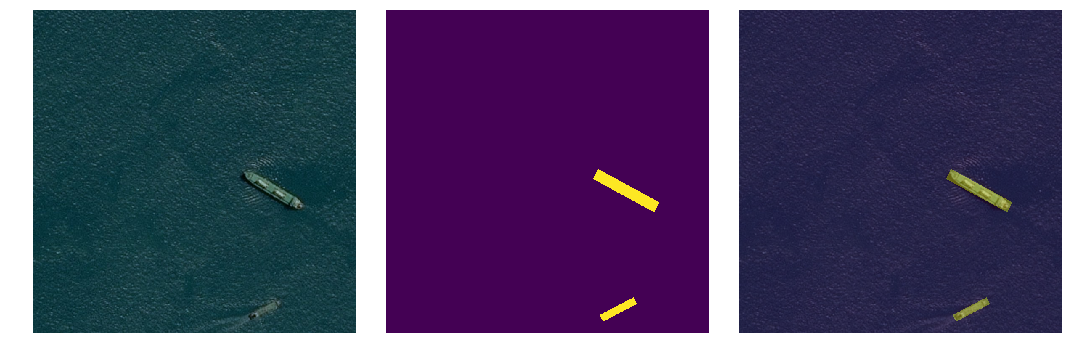

In [10]:
show_imgmasks(img, masks)

### check all training data

In [33]:
img_ids = train_seg_lbs.ImageId.unique() # pick an image from training folder

In [34]:
len(img_ids)

38300

In [ ]:
for img_id in img_ids:
    rles = train_seg_lbs[train_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    print(f"number of masks : {len(rles)}")
    # get image and mask
    img = open_image(str(path/"train_all"/img_id))
    masks = sum([rle_decode(rle, img.shape[:2]) for rle in rles])
    show_imgmasks(img, masks)

### check all test data

**note: this is our test set, actual will be later provided**

In [ ]:
img_ids = train_seg_lbs.ImageId.unique() # pick an image from training folder

In [ ]:
len(img_ids)

In [ ]:
for img_id in img_ids:
    rles = train_all_seg_lbs[train_all_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    print(f"number of masks : {len(rles)}")
    # get image and mask
    img = open_image(str(path/"test_all"/img_id))
    masks = sum([rle_decode(rle, img.shape[:2]) for rle in rles])
    show_imgmasks(img, masks)

### save all masks 

Having rle_decode inside get_y is very expensive

In [17]:
trn_unique_img_ids = train_seg_lbs.ImageId.unique()
test_unique_img_ids = test_seg_lbs.ImageId.unique()

In [35]:
len(trn_unique_img_ids), len(test_unique_img_ids)

(38300, 4256)

In [20]:
os.makedirs(path/'segmentations/train_masks', exist_ok=True)
os.makedirs(path/'segmentations/test_masks', exist_ok=True)

In [31]:
# save training
for img_id in trn_unique_img_ids:
    rles = train_seg_lbs[train_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    masks = sum([rle_decode(rle, (768, 768)) for rle in rles])
    plt.imsave(str(path/'segmentations/train_masks'/img_id), masks)

In [33]:
# save test
for img_id in test_unique_img_ids:
    rles = test_seg_lbs[test_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    masks = sum([rle_decode(rle, (768, 768)) for rle in rles])
    plt.imsave(str(path/'segmentations/test_masks'/img_id), masks)

### dynamic unet segmentation 

In [11]:
from fastai.models.unet import *
from fastai.dataset import *
from fastai.core import *

In [12]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [13]:
train_seg_lbs.ImageId.nunique(), test_seg_lbs.ImageId.nunique()

(38300, 4256)

In [14]:
train_seg_lbs.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...


In [15]:
unique_img_ids = train_seg_lbs.ImageId.unique()
trn_fnames, val_fnames = train_test_split(unique_img_ids, test_size=0.1, random_state=42)

In [16]:
TRN_X = [f"train_all/{fname}" for fname in trn_fnames]
TRN_Y = [f"segmentations/train_masks/{fname}" for fname in trn_fnames]

VAL_X = [f"train_all/{fname}" for fname in val_fnames]
VAL_Y = [f"segmentations/train_masks/{fname}" for fname in val_fnames]

In [17]:
sz = 256

class FilesEncodedDataset(BaseDataset):
    def __init__(self, fnames, fnames2, transform, path):
        self.fnames = fnames
        self.fnames2 = fnames2
        self.path = path
        super().__init__(transform)
    
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): 
        mask = cv2.imread(os.path.join(self.path, self.fnames2[i]), cv2.IMREAD_GRAYSCALE)
        mask = (mask - 30)/185
        return cv2.resize(mask, (sz, sz)).astype('float32')
        
    def get_n(self): return len(self.fnames)
    def get_c(self): return 0

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [18]:
f = resnet18
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats

In [19]:
dataset = ImageData.get_ds(FilesEncodedDataset, (TRN_X, TRN_Y),
                           (VAL_X, VAL_Y),
                           tfms=tfms, path = path)

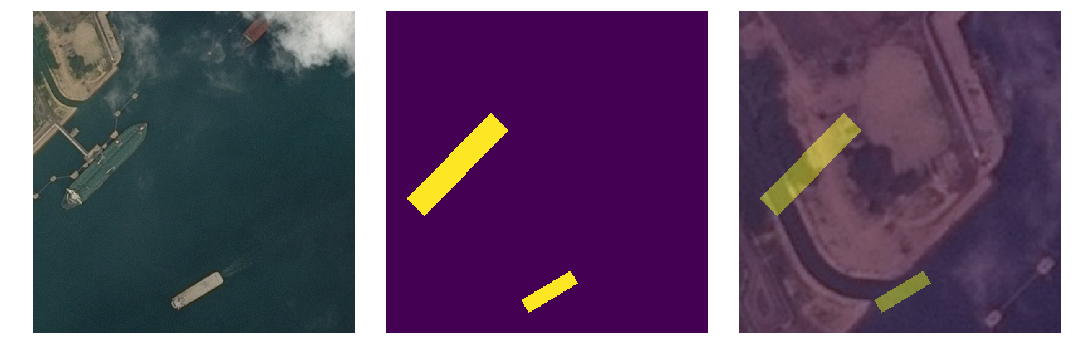

In [20]:
i = 111
x,y = dataset[0].get_x(i), dataset[0].get_y(i)
show_imgmasks(x,y)

In [21]:
md = ImageData(path, dataset, bs=16, num_workers=16, classes=None)

In [22]:
x, y = next(iter(md.trn_dl))

In [23]:
x.shape, y.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))

### model

In [24]:
# load defined model# load  
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

def get_model(sz=128):
    """gets dynamic unet model"""
    # choose encoder
    f = resnet18
    cut, cut_lr = model_meta[f]
    cut, cut_lr

    # define encoder
    encoder = get_encoder(f, cut)

    # init model
    m = DynamicUnet(encoder, n_classes=1) # binary: ship - not ship

    # init upsample on cpu
    inp = torch.ones(1, 3, sz, sz)
    out = m(V(inp).cpu())

    # put model to gpu if desired# put mo 
    m = m.cuda(0)
    return m

In [25]:
class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        return F.binary_cross_entropy_with_logits(logits, targets)

In [26]:
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [50]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 1550/2155 [05:51<02:17,  4.40it/s, loss=0.034]  

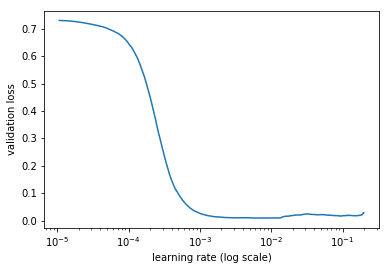

In [51]:
learn.sched.plot()

### evaluation metric

- we need indv. GT and predicted labels

In [27]:
from skimage.measure import label

In [28]:
train_seg_lbs.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...


In [29]:
def sigmoid(x): return 1  /(1 + np.exp(-x))

In [191]:
mask_thresh = 0.5
x,y = next(iter(md.val_dl))
preds = learn.predict_array(to_np(x))
preds = preds.squeeze(1)
# final form
preds = (sigmoid(preds) > mask_thresh).astype('uint8')
gt = to_np(y)

In [192]:
# calculate F2 for image i
i = 0
gt_i = gt[i]
pred_i = preds[i] > thresh
fnames = md.val_ds.fnames
fname = fnames[i]

In [167]:
gt_rles_i = train_seg_lbs[train_seg_lbs.ImageId == fname.split("/")[-1]]['EncodedPixels'].values

In [168]:
f"number of ships in image {i} is {len(gt_rles_i)}"

'number of ships in image 0 is 1'

In [169]:
# get connected components in predictions
labels = label(pred_i)

In [170]:
uniq_labels = np.unique(labels)

In [171]:
f"number of ships predicted in image {i} is {len(uniq_labels)-1}"

'number of ships predicted in image 0 is 0'

In [30]:
def get_pred_masks(labels, uniq_labels):
    """assuming all images are 768x768 originally"""
    pred_mask_arrays = []
    for l in uniq_labels[1:]:
        pred_mask = cv2.resize((labels == l).astype(np.uint8), (768, 768))
        pred_mask_arrays.append(pred_mask)
    return pred_mask_arrays

In [31]:
def get_gt_masks(gt_rles_i):
    """assuming all images are 768x768 originally"""
    gt_mask_arrays = []
    for gt_rle in gt_rles_i:
        gt_mask = rle_decode(gt_rle, (768, 768)) 
        gt_mask_arrays.append(gt_mask)
    return gt_mask_arrays

In [32]:
# Create IOU matrix preds x actual
def create_iou_matrix(pred_mask_arrays, gt_mask_arrays):
    IOU = []
    for pred_mask in pred_mask_arrays:
        for gt_mask in gt_mask_arrays:
            intersection = np.sum(pred_mask*gt_mask)
            union = np.sum((pred_mask+gt_mask)>0)
            IOU.append(intersection/union)
    # reshape
    n_preds = len(pred_mask_arrays)
    n_gt = len(gt_mask_arrays)
    IOU = np.array(IOU)
    return IOU.reshape(n_preds, n_gt)

In [33]:
def f2_score(tp, fp, fn):
    beta = 2
    return (1+beta**2)*tp / ((1+beta**2)*tp + (beta**2)*fn + fp)

In [34]:
def f2_IOU(IOU):
    """
    Calculate mean thresholded f2 score for an image and it's
    predictions.
    """
    if IOU is None:
        """no predictions is made even image has ships"""
        return 0
    else:
        """calculates metric from IOU matrix"""
        avg_f2 = 0
        for t in np.arange(0.5, 1.0, 0.05):
            IOU_at_t = (IOU > t)*1
            tp = IOU_at_t.sum()
            fp = np.sum(np.sum(IOU_at_t, axis=1) == 0)
            fn = np.sum(np.sum(IOU_at_t, axis=0) == 0)
            f2 = f2_score(tp, fp, fn)
            avg_f2 += f2
        avg_f2 /= 10
    return avg_f2

In [188]:
if len(uniq_labels) == 1:
    IOU = None
else:
    pred_mask_arrays = get_pred_masks(labels, uniq_labels)
    gt_mask_arrays = get_gt_masks(gt_rles_i)
    IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
f2_IOU(IOU)

0

### test metric

ref: https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric

In [41]:
shift = 0 # shift to keep track of file index 
n_valids = len(md.val_ds) # total # of validation samples
def metric(preds, targs):
    global shift
    global train_seg_lbs
    scores = []
    
    # number of objects
    n_x = len(preds)
    mask_thresh = 0.5 # can be tuned
    preds = to_np(preds)
    preds = preds.squeeze(1)
    # final form
    preds = (sigmoid(preds) > mask_thresh).astype('uint8')
    gt = to_np(targs)
    
    # calculate F2 for image i
    for i in range(len(preds)):
        gt_i = gt[i]
        pred_i = preds[i] > mask_thresh
        fnames = md.val_ds.fnames
        fname = fnames[i+shift]

        gt_rles_i = train_seg_lbs[train_seg_lbs.ImageId == fname.split("/")[-1]]['EncodedPixels'].values
        # get connected components in predictions
        labels = label(pred_i)
        uniq_labels = np.unique(labels)

        if len(uniq_labels) == 1:
            IOU = None
        else:
            pred_mask_arrays = get_pred_masks(labels, uniq_labels)
            gt_mask_arrays = get_gt_masks(gt_rles_i)
            IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
        scores.append(f2_IOU(IOU))
    shift += n_x
    if shift == n_valids: shift = 0
    return np.round(np.mean(scores), 4)

### train with eval metric

In [42]:
cut, cut_lr = model_meta[f]

In [43]:
model = get_model(sz=256)
models = UpsampleModel(model, cut_lr)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = BCELoss2D()
learn.metrics = [metric]

In [45]:
learn.fit(1e-3, 10, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  0%|          | 7/2155 [00:03<16:23,  2.19it/s, loss=0.00552]


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   metric                          
    0      0.004688   0.004737   0.230504  
    1      0.004492   0.004508   0.261982                        
    2      0.003829   0.003895   0.271324                        
    3      0.003648   0.003781   0.291828                        
    4      0.003431   0.003438   0.297322                        
    5      0.002894   0.003504   0.307007                        
    6      0.002972   0.003231   0.310115                        
Validation:  69%|██████▉   | 166/240 [01:47<00:47,  1.55it/s]    

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


    7      0.002715   0.003172   0.317068                    
    8      0.002535   0.003475   0.320614                        
    9      0.00249    0.003241   0.320971                        



[array([ 0.00324]), 0.32097133159268931]

In [46]:
learn.save("seg_ckpt1")
learn.load("seg_ckpt1")

### train earlier layers

In [47]:
learn.unfreeze()

In [48]:
lr = 1e-3
lrs = [lr/100, lr/10, lr]
learn.fit(lrs, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   metric                          
    0      0.003273   0.00336    0.301546  
    1      0.002857   0.003095   0.31994                         
Validation:  95%|█████████▌| 228/240 [02:13<00:07,  1.70it/s]    

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


    2      0.002858   0.033214   0.322358                    
    3      0.002647   0.007391   0.323107                        
    4      0.002545   0.002834   0.327517                        



[array([ 0.00283]), 0.32751749347258485]

In [49]:
learn.save("seg_ckpt2")
learn.load("seg_ckpt2")